In [3]:
from __future__ import absolute_import, division, print_function

In [52]:
import os
import json
import pandas as pd
import glob
import numpy as np
import sys
import time
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from scipy import stats

## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

%matplotlib inline


# Define function to find local maxima in narray

In [238]:
def find_local_max(inarr,win=3,style='mode',level=3):
    """
    Find the local maxima in an array.
    
    The input array should be a (NxN) numpy array.
    
    A window of size (win)x(win) is used.
    Window size win needs to be an odd number
    to have a defined center pixel. If win is even, 
    it is autamtically increased by +1.
    
    The output is a mask of size equal to the input array 
    (NxN) with 0, unless a pixel is identified as a maximum.
    
    The maxima are evaluated base on 'style' using 'level'. 
    E.g., for 'style=mode' and 'level=3', a local maximum if 
    found is retained if its value is 3 times the mode of the
    image.
    """
    # check input
    if win%2 == 0:
        win += 1
    # create empty mask
    shp = inarr.shape
    mask = np.zeros(shape=shp)
    # central index of window
    win_idx = int(np.floor(win/2.)) 
    cen_idx = (win_idx,win_idx)
    win_mask = np.zeros(shape=(win,win))
    win_mask[cen_idx] = 1
    comp_mask = win_mask == 0
    val_mask = win_mask == 1
    xlen = len(inarr[:,0])
    ylen = len(inarr[:,1])
    # determine more in array
    inarr_ravel = inarr.ravel()
    tmp_list = np.ndarray.tolist(inarr_ravel)
    tmp_mode = Counter(tmp_list).most_common(1)[0][0]
    cutoff = level*tmp_mode
    print('Mode: ',tmp_mode)
    print('Mean: ', np.mean(inarr_ravel))
    print('Median: ', np.median(inarr_ravel))
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)
    final_mask = mask == 1
    return final_mask
        

# Get coordinates for CA state

In [248]:
# Get CA coordinates
infile = os.path.join('..','..','data','ca_shape.csv')
ca_shape = pd.read_csv(infile)
x_coords = ca_shape['longitude'].tolist()
y_coords = ca_shape['latitude'].tolist()


# Get data from pickle

In [6]:
# import pre-selected and pickled dataframe
start_time = time.time()
flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
print("--- %s seconds ---" % (time.time() - start_time))


--- 26.6292099953 seconds ---


# Select subset of data

In [241]:
keyword = 'dog'
keyword = 'skateboard'
keyword = 'toyota'

In [244]:
# Select subset based on keyword
start_time = time.time()
flickr_all_clean_dogs = flickr_all_clean[flickr_all_clean['title_tags'].str.contains(keyword, na=False)]
print("--- %s seconds ---" % (time.time() - start_time))
print(flickr_all_clean_dogs.shape)

--- 3.1581659317 seconds ---
(3020, 8)


In [245]:
df = flickr_all_clean_dogs

# Select based on longitude / latitude range

In [249]:
# Extract long/lat and combine into 2d array
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
limit_lng = [-122.7,-121.8]
limit_lat = [36.9,38.3]
#
#limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
XY = np.vstack([yin.ravel(), xin.ravel()]).T

# Run KDE

In [250]:
lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy *= np.pi / 180.
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians
#
kde = KernelDensity(bandwidth=0.0003)
kde.fit(Xtrain)
#
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# Find local maxima in KDE estimates

In [251]:
local_maxima_map = find_local_max(Z,win=3,level=1)
xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                      Y.reshape(local_maxima_map.shape)[local_maxima_map])).T

print(xy_maxima[:,0])
print(len(xy_maxima))

Mode:  3.74985112578e-12
Mean:  2836.83719675
Median:  6.16078927515
[-122.02232714 -121.96285571 -122.27720472 -122.37915575 -122.03931898
 -121.86090468 -121.90338427 -121.93736795 -122.0053353  -122.2687088
 -121.97135163 -122.09879041 -121.97984755 -121.91188019 -122.16675777
 -122.4471231  -121.92887203 -122.51509045 -122.37915575 -122.30269247
 -121.97135163 -122.37915575 -121.87789652 -122.4471231  -121.96285571
 -122.47261086 -122.12427817 -121.95435979 -121.89488835 -122.65952108
 -122.20074144 -122.07330266 -122.39614759 -121.92037611 -121.99683938
 -122.29419656 -122.45561902 -121.94586387 -122.63403332 -122.54907413
 -122.06480674 -122.15826185 -121.95435979 -122.54057821 -122.03931898
 -122.2687088  -122.16675777 -122.55757005 -122.24322104 -122.45561902
 -122.41313942 -122.65952108 -122.03082306]
53


# Plot results

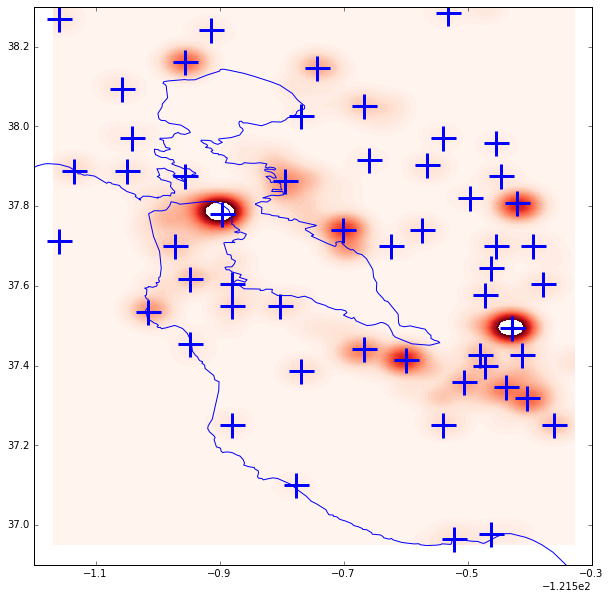

In [252]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
levels = np.linspace(0, np.log10(Z.max()), 50)
levels = np.linspace(0, np.sqrt(Z.max())-np.sqrt(Z.max())/3, 50)
plt.contourf(X, Y, np.sqrt(Z), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', markersize=25,markeredgewidth=3,markeredgecolor='b')
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.8,38.5) 
#
plt.show()

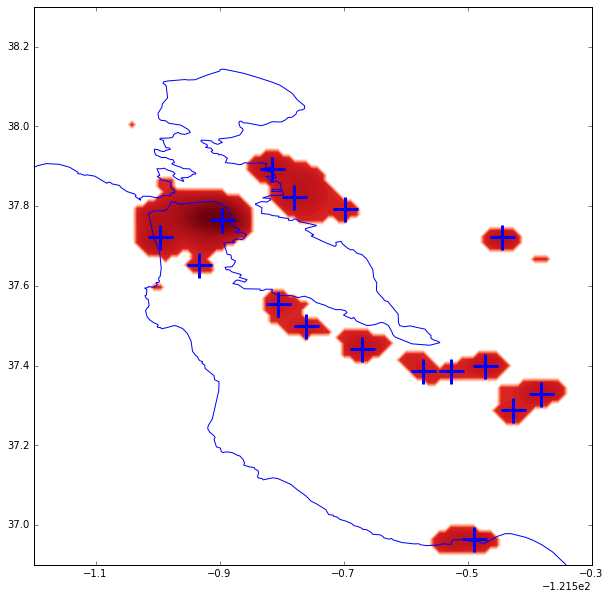

In [209]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  determine mode level
inarr_ravel = Z.ravel()
tmp_list = np.ndarray.tolist(inarr_ravel)
tmp_mode = Counter(tmp_list).most_common(1)[0][0]
cutoff = 3.0*tmp_mode
# Set Z to zero under threshold
low_idx = Z < cutoff
Z_low = copy.copy(Z)
Z_low[low_idx] = 0.1
#  plot contours of the density
levels = np.linspace(0, np.log10(Z_low.max()), 50)
#levels = np.linspace(0, Z_low.max(), 100)
plt.contourf(X, Y, np.log10(Z_low), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', markersize=25,markeredgewidth=3,markeredgecolor='b')
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.8,38.5) 
#
plt.show()

# Plot histogram of KDE

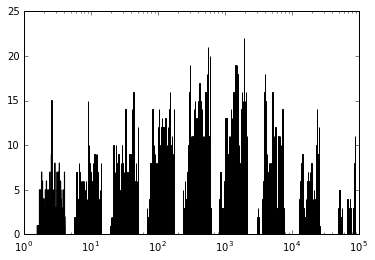

In [261]:

# # the histogram of the data
# n, bins, patches = plt.hist(Z, 50, normed=1, facecolor='green', alpha=0.75)


# # plt.xlabel('Smarts')
# # plt.ylabel('Probability')
# # plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
# # plt.axis([40, 160, 0, 0.03])
# # plt.grid(True)

# plt.show()


plt.hist(Z, bins=np.logspace(0.1, 5, 10))
plt.gca().set_xscale("log")
plt.show()

In [ ]:
# Toyota example
# Mode:  3.74985112578e-12
# Mean:  2836.83719675
# Median:  6.16078927515
